In [3]:


import torch

from torch.utils.data import Dataset, DataLoader



from torchvision import transforms as T, utils

import matplotlib.pyplot as plt
from PIL import Image





#ab diffusion related imports
#from AB_diffusion.user_hints import RandomHintGenerator, get_color_hints 
from AB_diffusion.color_handling import de_normalize_lab, normalize_lab,plotMinMax
from AB_diffusion.ab_denoising_diffusion_pytorch import ABUnet, ABGaussianDiffusion
from AB_diffusion.ab_trainer import ABDataset
from AB_diffusion.colorizer_app import ColorizerApp
from IPython.utils import io as iol
from skimage import io
from kornia.color import rgb_to_lab, lab_to_rgb
from datasets import load_from_disk,load_dataset
#from ab_classifier_free_guidance import *


import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import random
import glob
import mplcursors
import ipywidgets as widgets
from IPython.display import display
import torchvision.transforms as transforms


In [144]:
class HintGenerator:
    def __init__(self, hint_size_range=[1, 9], p=1/8, reveal_all_rate=0.01, mu_factor=2, sigma_factor=4):
        self.hint_size_range = hint_size_range
        self.p = p
        self.reveal_all_rate = reveal_all_rate
        self.mu_factor = mu_factor
        self.sigma_factor = sigma_factor
    
    def generate_hints(self, color_images):
        B, C, H, W = color_images.shape
        B_ab = torch.zeros((B, H, W, 2), device=color_images.device, dtype=color_images.dtype)
        
        for i in range(B):
            num_hints = self._sample_num_hints()
            for _ in range(num_hints):
                self._place_hint(B_ab[i], color_images[i])
        
        # Special case: Copy entire AB channel for a certain percentage of instances
        num_full_copy = int(B * self.reveal_all_rate)
        full_copy_indices = torch.randint(0, B, (num_full_copy,))
        
        for idx in full_copy_indices:
            #print(B_ab[idx].shape,"B_ab")
            #print(color_images[idx].shape,"color")
            B_ab[idx] = color_images[idx].clone().permute(1, 2, 0)
        
        return B_ab.permute(0, 3, 1, 2)
    
    def _place_hint(self, B_ab, color_image):
        H, W = B_ab.shape[:2]
        hint_size = self._sample_hint_size()
        hint_location = self._sample_hint_location(H, W)
        
        y, x = hint_location
        h, w = hint_size
    
        # Ensure the hint patch is completely within the image boundaries
        y = min(max(0, y), H - h)
        x = min(max(0, x), W - w)
        
        # Extract the patch from the ground truth AB channels
        # Ensure we are extracting a 2D region from both the A and B channels
        patch = color_image[:, y:y+h, x:x+w]
        
        # Debug: Print the shape of the patch
        #print("Patch Shape:", patch.shape)
        
        # Compute the mean across the spatial dimensions (1 and 2) 
        # to get an average color with two components (A and B)
        patch_mean = torch.mean(patch, dim=(1, 2))
        
        # Debug: Print the shape of patch_mean
        #print("Patch Mean Shape:", patch_mean.shape)
        
        # Assign this average color to the hint patch in B_ab
        B_ab[y:y+h, x:x+w, 0] = patch_mean[0]
        B_ab[y:y+h, x:x+w, 1] = patch_mean[1]

    def _sample_hint_location(self, H, W):
        mu = torch.tensor([H / self.mu_factor, W / self.mu_factor])
        sigma = torch.tensor([(H / self.sigma_factor) ** 2, (W / self.sigma_factor) ** 2])
        return torch.normal(mean=mu, std=sigma.sqrt()).to(dtype=torch.int)

    def _sample_hint_size(self):
        size = np.random.randint(self.hint_size_range[0], self.hint_size_range[1] + 1)
        return (size, size)

    def _sample_num_hints(self):
        return np.random.geometric(p=self.p)


In [138]:
device = torch.device(0 if torch.cuda.is_available() else "cpu")
print(device)
print("Selected GPU:", torch.cuda.get_device_name(device))
#check wicj gpu is selected
torch.cuda.set_device(device)

test_folder = "./data/SEM images/val"

#dataset = ABDataset(load_dataset("imagenet-1k",split="validation"),image_size=256)
dataset = ABDataset(load_dataset("imagefolder", data_dir=test_folder)["train"],image_size=256)
dataloader = DataLoader(dataset, batch_size = 1, shuffle = True, pin_memory = True,num_workers=8)

cuda:0
Selected GPU: NVIDIA GeForce RTX 3080


Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Using custom data configuration default-841814c47f125efb
Found cached dataset imagefolder (C:/Users/emive/.cache/huggingface/datasets/imagefolder/default-841814c47f125efb/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

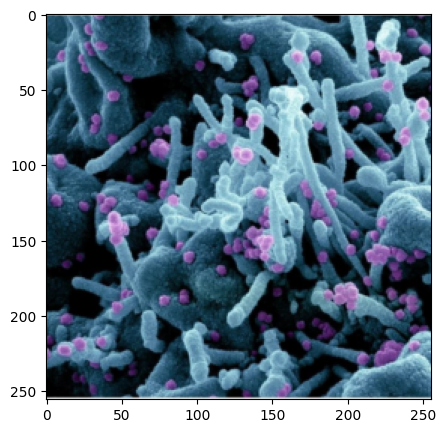

In [112]:
imgL, imgAB = next(iter(dataloader))

#cat them together, convert to rgb and display
imgLAB = torch.cat((imgL,imgAB),dim=1)
imgRGB = transforms.ToPILImage()(
            lab_to_rgb(
                de_normalize_lab(imgLAB).squeeze(0).detach().cpu()
            )
        )


# display imgRGB in notebook, i want it to be atleast 7 inches wide
plt.figure(figsize=(5,5))
plt.imshow(imgRGB)
plt.show()


torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])


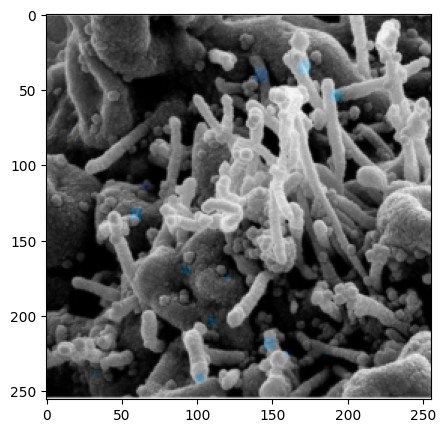

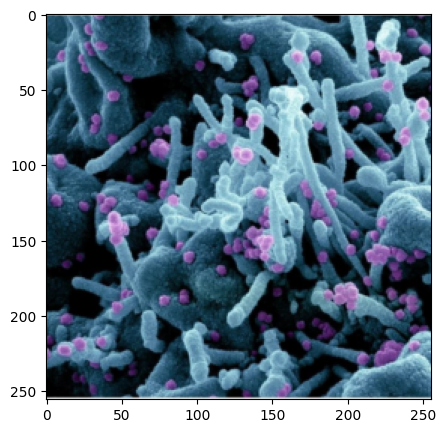

In [145]:
print(imgAB.shape)
hintgen = HintGenerator(hint_size_range=[1, 9], p=1/8, reveal_all_rate=0.01, mu_factor=2, sigma_factor=4)
hints = hintgen.generate_hints(imgAB)
print(hints.shape)

img_w_hints = transforms.ToPILImage()(
        lab_to_rgb(
            de_normalize_lab(torch.cat((imgL, hints), 1)).squeeze(0).detach().cpu()
        )
    )
plt.figure(figsize=(5,5))
plt.imshow(img_w_hints)
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(imgRGB)
plt.show()

In [146]:
import time
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a dummy batch of 1000 images of size 64x64, with 3 channels (L, A, B)
num_images = 1000
H, W = 64, 64
dummy_images = torch.rand((num_images, 2, H, W), device=device)

# Initialize the HintGenerator
hintgen = HintGenerator(hint_size_range=[1, 9], p=1/8, reveal_all_rate=0.01, mu_factor=2, sigma_factor=4)

# Measure the start time
start_time = time.time()

# Generate hints using the AB channels
hints = hintgen.generate_hints(dummy_images)

# Measure the end time
end_time = time.time()

# Compute and print the elapsed time
elapsed_time = end_time - start_time
print("Elapsed Time:", elapsed_time, "seconds")



torch.Size([64, 64, 2]) B_ab
torch.Size([2, 64, 64]) color
torch.Size([64, 64, 2]) B_ab
torch.Size([2, 64, 64]) color
torch.Size([64, 64, 2]) B_ab
torch.Size([2, 64, 64]) color
torch.Size([64, 64, 2]) B_ab
torch.Size([2, 64, 64]) color
torch.Size([64, 64, 2]) B_ab
torch.Size([2, 64, 64]) color
torch.Size([64, 64, 2]) B_ab
torch.Size([2, 64, 64]) color
torch.Size([64, 64, 2]) B_ab
torch.Size([2, 64, 64]) color
torch.Size([64, 64, 2]) B_ab
torch.Size([2, 64, 64]) color
torch.Size([64, 64, 2]) B_ab
torch.Size([2, 64, 64]) color
torch.Size([64, 64, 2]) B_ab
torch.Size([2, 64, 64]) color
Elapsed Time: 2.8061978816986084 seconds


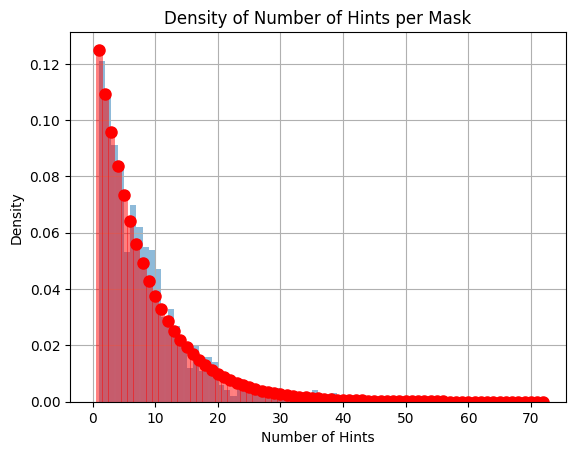

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import geom

# 1. Collect the number of hints for each image in the batch
# (Assuming the _sample_num_hints method is accessible; if not, it may need to be called within the generate_hints method)
num_hints_list = [hintgen._sample_num_hints() for _ in range(num_images)]

# 2. Plot the actual distribution of the number of hints
plt.hist(num_hints_list, bins=np.arange(0, max(num_hints_list)+2), density=True, alpha=0.5, label='Actual Distribution')

# 3. Plot the theoretical geometric distribution
p = hintgen.p  # Probability parameter for the geometric distribution
x = np.arange(1, max(num_hints_list)+2)
pmf = geom.pmf(x, p)
plt.plot(x, pmf, 'ro', ms=8, label='Theoretical Geometric Distribution')
plt.vlines(x, 0, pmf, colors='r', lw=5, alpha=0.5)

# Plot settings
plt.title('Density of Number of Hints per Mask')
plt.xlabel('Number of Hints')
plt.ylabel('Density')
plt.grid(True)
plt.show()

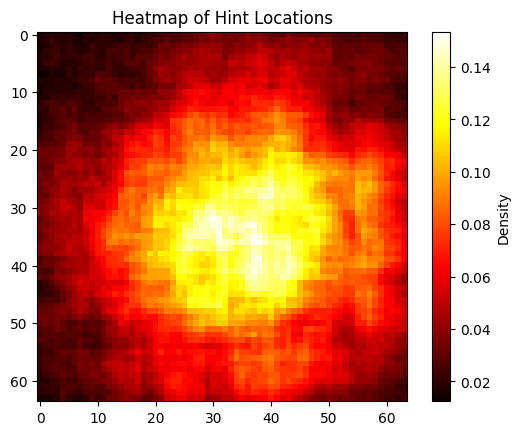

In [148]:
heatmap = torch.zeros((H, W), device=device)
for hint in hints:
    heatmap += hint.sum(dim=0)

# Normalize the heatmap
heatmap /= num_images

# Move the heatmap to CPU and convert to numpy array for plotting
heatmap = heatmap.cpu().numpy()

# Plot the heatmap
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.title('Heatmap of Hint Locations')
plt.colorbar(label='Density')
plt.show()

In [153]:
from AB_diffusion.user_hints import RandomHintGenerator, get_color_hints 

hintgen2 = RandomHintGenerator(input_size = 64, hint_size=2, num_hint_range=[0, 10], uniform = False)

# Measure the start time
start_time = time.time()
masks = hintgen2(num_images)

hints = get_color_hints(imgAB = dummy_images, hints = masks, device = device)